In [145]:
import pandas as pd
import numpy as np
from numpy import diff

from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import ternary # ternary plot has a bug
import plotly.express as px
import h5py
import matplotlib as mpl

# import geopandas as gpd
import math

from matplotlib.patches import Circle, Wedge, Polygon

import os
import matplotlib.patheffects as path_effects


from netCDF4 import Dataset as NetCDFFile 

# for beachball - there are some error with using obspy
from pyrocko.plot import beachball
from pyrocko import moment_tensor as ptm

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from pathlib import Path
%matplotlib inline

import harmonica as hm

from obspy.core import UTCDateTime

from datetime import datetime, timezone

import seaborn as sns
sns.set()
sns.set_style(style='white') 
sns.set_style("ticks", {"xtick.major.size": 0.5, "ytick.major.size": 0.5})


#set the font globally
plt.rcParams.update({'font.family':'Helvetica'})

In [146]:
# data = pd.read_csv('sum_with_2005_eqs.csv', header = 'infer')
data = pd.read_csv("/Users/mohd0001/PhD_Monash/Paper2/time-series/data/SUeq_data.csv", header = 'infer')
# data.dtypes

In [147]:
# data = data[(data['MW'] >= 5.1)]

data.sort_values(by = 'MW', ascending = False, inplace = True)

data['DATE'] = pd.to_datetime(data['DATE']) # change dtype to datetime format
data['DATE'] = data['DATE'].dt.strftime('%Y-%m-%d') # change dtype to object

# data['DATE'] and data['TIME'] should be object (str) to perform + operator

data_dummy = np.array(data['DATE'] + ' ' + data['TIME'])

data_ev_time = []

for val in data_dummy:
    data_ev_time.append(UTCDateTime(val))

    
ref_date = data_ev_time[0]

data_ev_time = np.array(data_ev_time)

date = []

for val in data_ev_time:
    date.append(val - ref_date)
    
date = np.array(date) # this is in seconds

data['YEARS'] = date/31536000

data = data.sort_values(by ='YEARS', ascending=True) # this is an important step
# data = data[(data['DATE'] > '01-01-2003') & (data['DATE'] < '26-11-2004')]

In [148]:
# long slab

data_dgoing = data.loc[data['CLASS'] == 'DGOING']
data_dgoing = data_dgoing[(data_dgoing['LAT'] <= -2) & (data_dgoing['LON'] <= 120) &
                         (data_dgoing['DEPTH'] > 70) &
                         (data_dgoing['MW'] > 4)]

# # # short slab
# data_dgoing = data.loc[data['CLASS'] == 'DGOING']
# data_dgoing = data_dgoing[(data_dgoing['LAT'] > -2) &
#                          (data_dgoing['DEPTH'] > 70) &
#                          (data_dgoing['MW'] < 6 )]

### Yellow band - 2004 $M_w$ 9.0

/Users/mohd0001/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


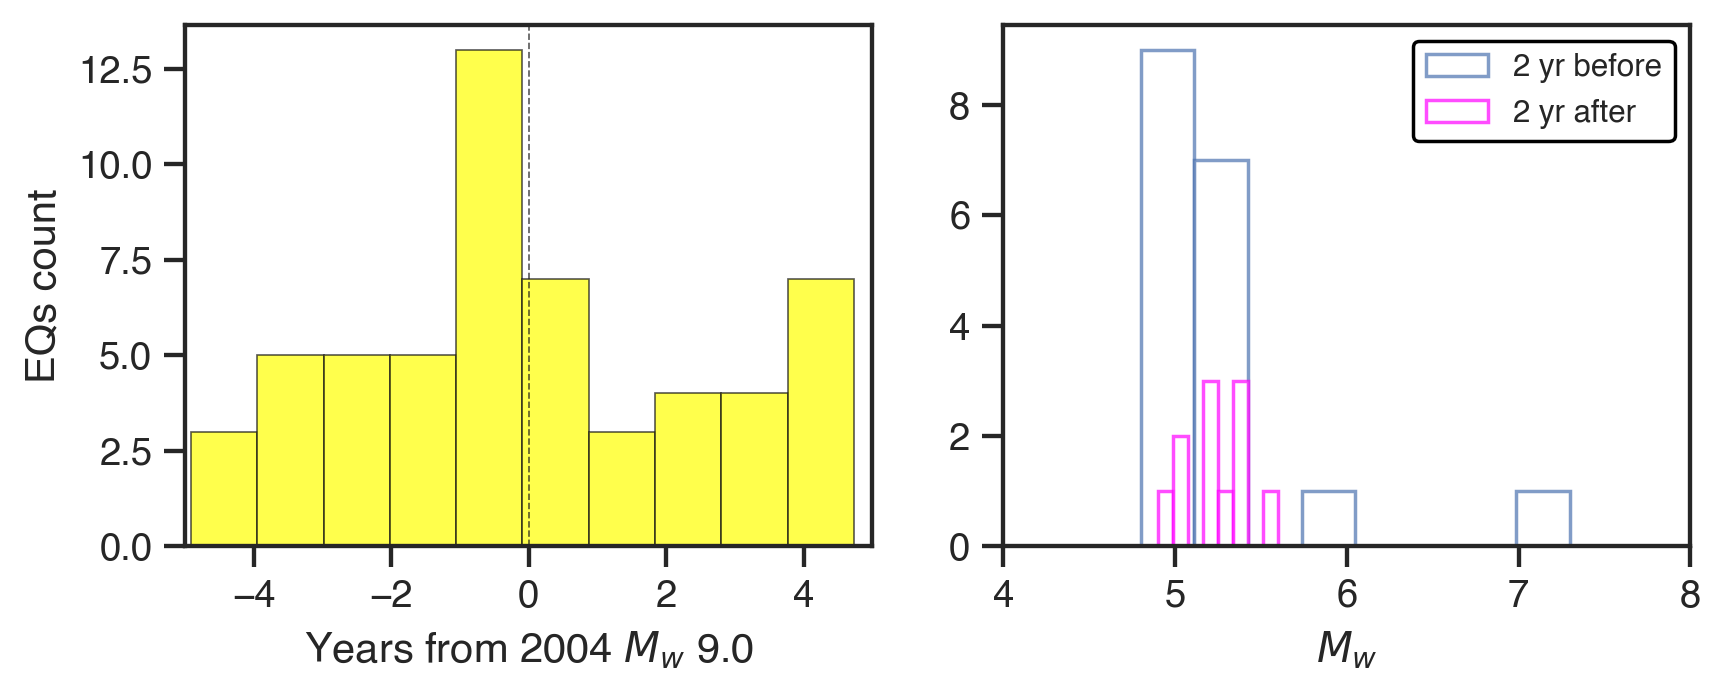

In [149]:
# yellow band

mega_yellow = 0
t1 = mega_yellow - 5
t2 = mega_yellow + 5

yellow_eq_Java = data_dgoing[(data_dgoing['YEARS'] > t1) & (data_dgoing['YEARS'] < t2)]

#normalize around megathrust earthquake for yellow band
yellow_eq_Java['YEARS'] = ((yellow_eq_Java['YEARS'] - mega_yellow))

# Convert year to months
# yellow_eq_Java['MONTHS'] = yellow_eq_Java['YEARS'] * 12

# counts
yellow_count = yellow_eq_Java.groupby('YEARS').size()


figsize = (7,3)
dpi=250

fig, ax = plt.subplots(1, 2, dpi=dpi, figsize = figsize, sharex= False)
fig1=ax[0]
fig2=ax[1]


## left plot - Eqs counts vs years
bins = 10
alpha = 0.7
lw =0.5

fig1.hist(yellow_count.index, bins=bins, weights=yellow_count.values,
          edgecolor='k', lw=lw, alpha=alpha, color='yellow')

fig1.set_xlabel('Years from 2004 $M_w$ 9.0')
fig1.set_ylabel('EQs count')

fig1.axvline(x=0, color='k', lw=0.5, ls='--', alpha=alpha)

fig1.set_xlim([-5, 5])
# fig1.set_ylim([0, 10])

plt.tight_layout()


## ####right plot - difference between counts +1/-1 years

before_eq = yellow_eq_Java[(yellow_eq_Java['YEARS'] <= 0) & (yellow_eq_Java['YEARS'] >= -2)]
after_eq = yellow_eq_Java[(yellow_eq_Java['YEARS'] > 0) & (yellow_eq_Java['YEARS'] < 2)]

before_eq = before_eq.MW
after_eq = after_eq.MW

bins = 8
fig2.hist(before_eq, color = 'white',edgecolor='b', bins=bins, lw=1, alpha=alpha, label='2 yr before')
fig2.hist(after_eq, color = 'white', edgecolor='magenta', bins=bins, lw=1, alpha=alpha, label='2 yr after')

fig2.set_xlim([4, 8])

fig2.set_xlabel('$M_w$')
# fig2.set_ylabel('Count')
fig2.legend(loc = 'upper right',
            fontsize = 9,
            facecolor="white",
            framealpha=1,
            edgecolor="black",
            markerscale=1)

# fig1.set_ylim([0, 4])
# fig2.set_ylim([0, 4])

# fig1.text(-5.3, 3.5, '(a)', fontsize=14)
# fig2.text(4.2, 3.5, '(b)', fontsize=14)


plt.savefig("/Users/mohd0001/PhD_Monash/Paper2/output/hist/Yellow-countsYears.pdf"
            , dpi = 500, transparent= True, bbox_inches='tight')

### Grey band - 2007 $M_w$ 8.5

/Users/mohd0001/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


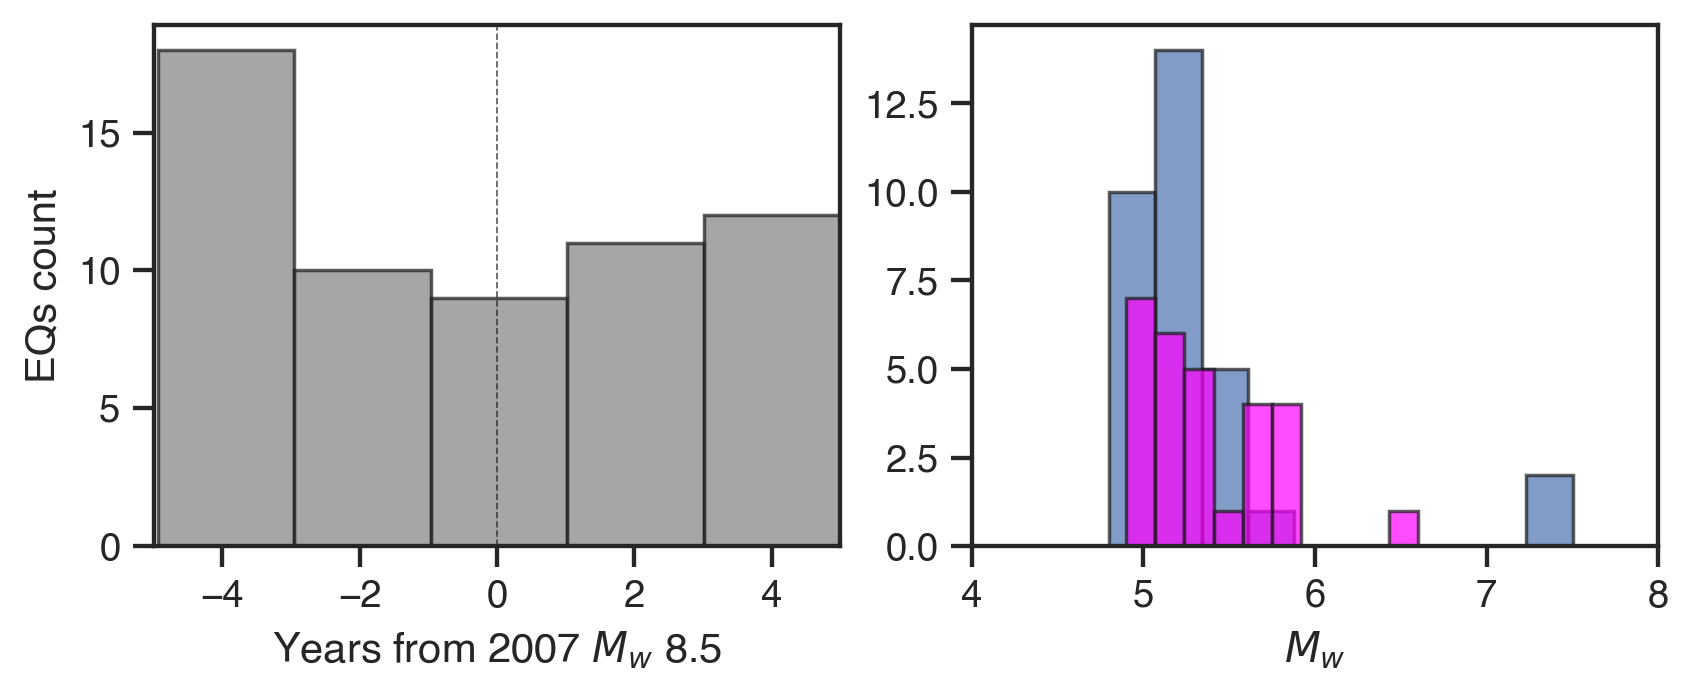

In [150]:
# grey band

mega_grey = 2.953983
t1 = mega_grey - 5
t2 = mega_grey + 5

grey_eq_Java = data_dgoing[(data_dgoing['YEARS'] > t1) & (data_dgoing['YEARS'] < t2)]

#normalize around megathrust earthquake for grey band
grey_eq_Java['YEARS'] = ((grey_eq_Java['YEARS'] - mega_grey))


# Convert year to months
# grey_eq_Java['MONTHS'] = grey_eq_Java['YEARS'] * 12

# counts
grey_count = grey_eq_Java.groupby('YEARS').size()


# figsize = (7,3)
# dpi=250

fig, ax = plt.subplots(1, 2, dpi=dpi, figsize = figsize, sharex= False)
fig1=ax[0]
fig2=ax[1]


## left plot - Eqs counts vs years
bins = 5
alpha = 0.7

fig1.hist(grey_count.index, bins=bins, weights=grey_count.values,
          edgecolor='k', lw=1, alpha=alpha, color='grey')

fig1.set_xlabel('Years from 2007 $M_w$ 8.5')
fig1.set_ylabel('EQs count')

fig1.axvline(x=0, color='k', lw=0.5, ls='--', alpha=alpha)

fig1.set_xlim([-5, 5])
# fig1.set_ylim([0, 10])

plt.tight_layout()


## ####right plot - difference between counts +1/-1 years

before_eq = grey_eq_Java[(grey_eq_Java['YEARS'] <= 0) & (grey_eq_Java['YEARS'] >= -5)]
after_eq = grey_eq_Java[(grey_eq_Java['YEARS'] > 0) & (grey_eq_Java['YEARS'] < 5)]

before_eq = before_eq.MW
after_eq = after_eq.MW

bins = 10
fig2.hist(before_eq, color='b', edgecolor='k', bins = bins, lw=1, alpha=alpha, label='1 yr before')
fig2.hist(after_eq, color='magenta', edgecolor='k', bins = bins, lw=1, alpha=alpha, label='1 yr after')

fig2.set_xlim([4, 8])

fig2.set_xlabel('$M_w$')


# fig1.set_ylim([0, 5])
# fig2.set_ylim([0, 3])

# fig1.text(-5.3, 3.5, '(c)', fontsize=14)
# fig2.text(4.2, 3.5, '(d)', fontsize=14)


plt.savefig("/Users/mohd0001/PhD_Monash/Paper2/output/hist/Grey-countsYears.pdf"
            , dpi = 500, transparent= True, bbox_inches='tight')

### Red band - 2001 $M_w$ 7.1

/Users/mohd0001/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/mohd0001/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


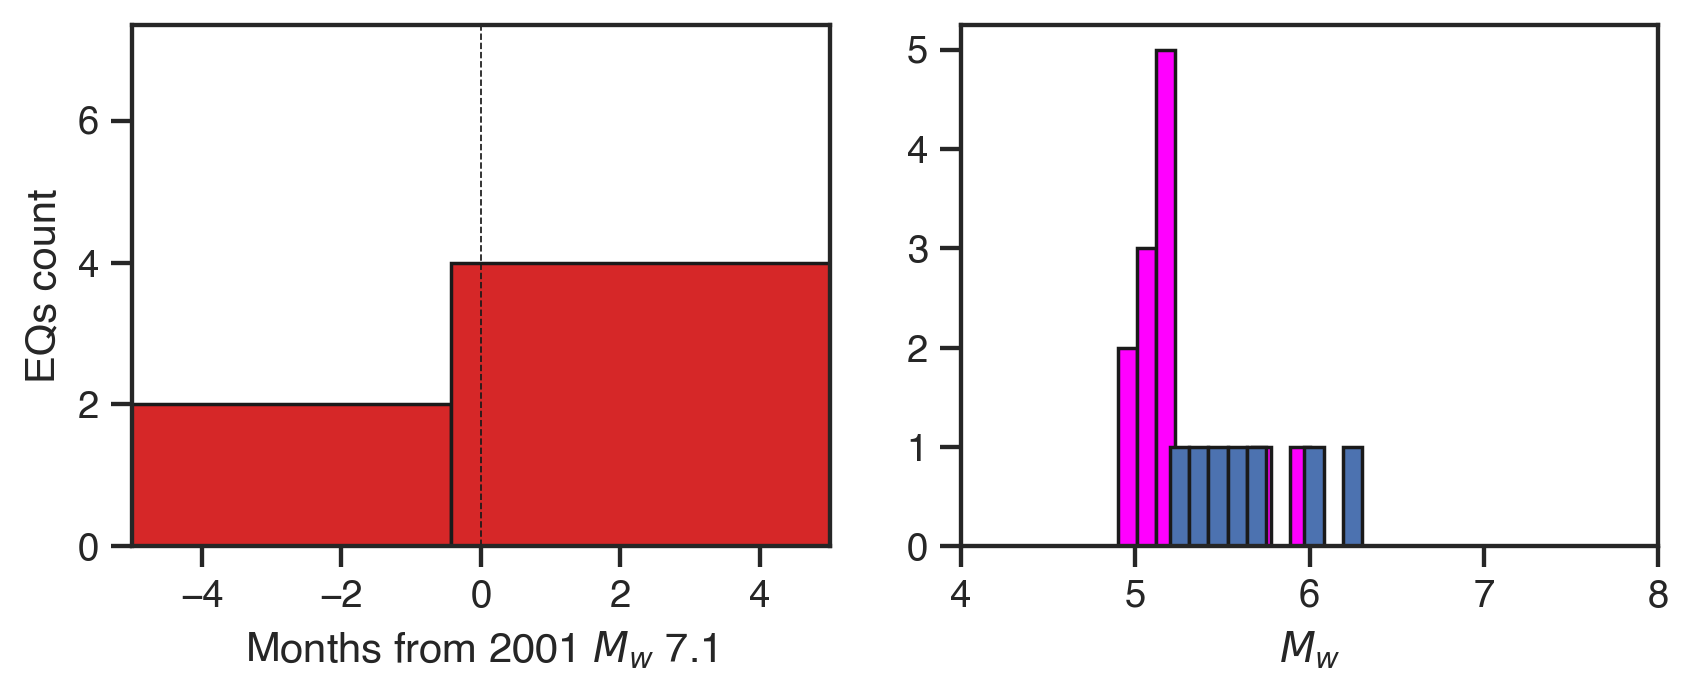

In [151]:
# red band

mega_red = -2.874320
t1 = mega_red - 5
t2 = mega_red + 5

red_eq_Java = data_dgoing[(data_dgoing['YEARS'] > t1) & (data_dgoing['YEARS'] < t2)]

#normalize around megathrust earthquake for red band
red_eq_Java['YEARS'] = ((red_eq_Java['YEARS'] - mega_red))

# Convert year to months
red_eq_Java['MONTHS'] = red_eq_Java['YEARS'] * 12

# counts
red_count = red_eq_Java.groupby('MONTHS').size()


# figsize = (7,3)
# dpi=250

fig, ax = plt.subplots(1, 2, dpi=dpi, figsize = figsize, sharex= False)
fig1=ax[0]
fig2=ax[1]


## left plot - Eqs counts vs years
bins = 20
alpha = 1

fig1.hist(red_count.index, bins=bins, weights=red_count.values,
          edgecolor='k', lw=1, alpha=alpha, color='tab:red')


# fig1.legend(loc = 'upper left',
#             fontsize = 10,
#             facecolor="white",
#             framealpha=1,
#             edgecolor="black",
#             markerscale=1)

fig1.set_xlabel('Months from 2001 $M_w$ 7.1')
fig1.set_ylabel('EQs count')

fig1.axvline(x=0, color='k', lw=0.5, ls='--', alpha=alpha)

fig1.set_xlim([-5, 5])
# fig1.set_ylim([0, 10])

plt.tight_layout()


## ####right plot - difference between counts +1/-1 years

before_eq = red_eq_Java[(red_eq_Java['YEARS'] <= 0) & (red_eq_Java['YEARS'] >= -2)]
after_eq = red_eq_Java[(red_eq_Java['YEARS'] > 0) & (red_eq_Java['YEARS'] < 2)]

before_eq = before_eq.MW
after_eq = after_eq.MW

bins = 10
fig2.hist(after_eq, color='magenta', edgecolor='k', bins = bins, lw=1, alpha=alpha, label='1 yr after')
fig2.hist(before_eq, color='b', edgecolor='k', bins = bins, lw=1, alpha=alpha, label='1 yr before')

fig2.set_xlim([4, 8])

fig2.set_xlabel('$M_w$')
# fig2.set_ylabel('Count')
# fig2.legend(loc = 'upper right',
#             fontsize = 10,
#             facecolor="white",
#             framealpha=1,
#             edgecolor="black",
#             markerscale=1)


plt.savefig("/Users/mohd0001/PhD_Monash/Paper2/output/hist/Red-countsYears.pdf"
            , dpi = 500, transparent= True, bbox_inches='tight')

### Purple band - 1994 $M_w$ 6.3, 6.4

/Users/mohd0001/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/mohd0001/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


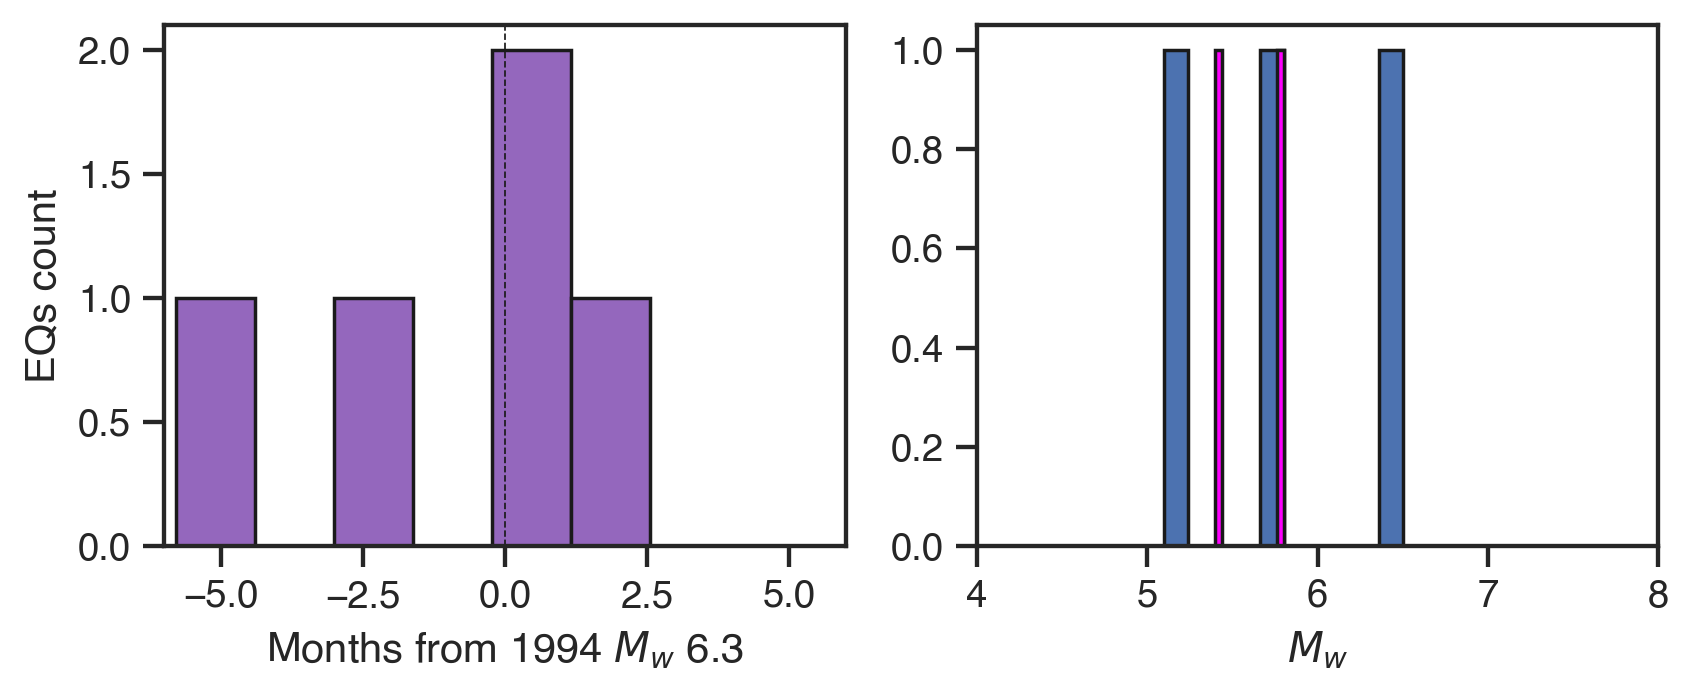

In [152]:
# purple band (Mw 6.3, 1995-05-11)

mega_purple = -9.635957
t1 = mega_purple - 0.5
t2 = mega_purple + 0.5

purple_eq_Java = data_dgoing[(data_dgoing['YEARS'] > t1) & (data_dgoing['YEARS'] < t2)]

#normalize around megathrust earthquake for purple band
purple_eq_Java['YEARS'] = ((purple_eq_Java['YEARS'] - mega_purple))

# Convert year to months
purple_eq_Java['MONTHS'] = purple_eq_Java['YEARS'] * 12

# counts
purple_count = purple_eq_Java.groupby('MONTHS').size()


# figsize = (7,3)
# dpi=250

fig, ax = plt.subplots(1, 2, dpi=dpi, figsize = figsize, sharex= False)
fig1=ax[0]
fig2=ax[1]


## left plot - Eqs counts vs years
bins = 6
alpha = 1

fig1.hist(purple_count.index, bins=bins, weights=purple_count.values,
          edgecolor='k', lw=1, alpha=alpha, color='tab:purple')


# fig1.legend(loc = 'upper left',
#             fontsize = 10,
#             facecolor="white",
#             framealpha=1,
#             edgecolor="black",
#             markerscale=1)

fig1.set_xlabel('Months from 1994 $M_w$ 6.3')
fig1.set_ylabel('EQs count')

fig1.axvline(x=0, color='k', lw=0.5, ls='--', alpha=alpha)

fig1.set_xlim([-6, 6])
# fig1.set_ylim([0, 10])

plt.tight_layout()


## ####right plot - difference between counts +1/-1 years

before_eq = purple_eq_Java[(purple_eq_Java['YEARS'] <= 0) & (purple_eq_Java['YEARS'] >= -0.5)]
after_eq = purple_eq_Java[(purple_eq_Java['YEARS'] > 0) & (purple_eq_Java['YEARS'] < 0.5)]

before_eq = before_eq.MW
after_eq = after_eq.MW

bins = 10
fig2.hist(before_eq, color='b', edgecolor='k', bins = bins, lw=1, alpha=alpha, label='1 yr before')
fig2.hist(after_eq, color='magenta', edgecolor='k', bins = bins, lw=1, alpha=alpha, label='1 yr after')

fig2.set_xlim([4, 8])

fig2.set_xlabel('$M_w$')
# fig2.set_ylabel('Count')
# fig2.legend(loc = 'upper right',
#             fontsize = 10,
#             facecolor="white",
#             framealpha=1,
#             edgecolor="black",
#             markerscale=1)


plt.savefig("/Users/mohd0001/PhD_Monash/Paper2/output/hist/Purple-countsYears.pdf"
            , dpi = 500, transparent= True, bbox_inches='tight')

### Maroon band - 1992 $M_w$ 1992

/Users/mohd0001/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/mohd0001/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


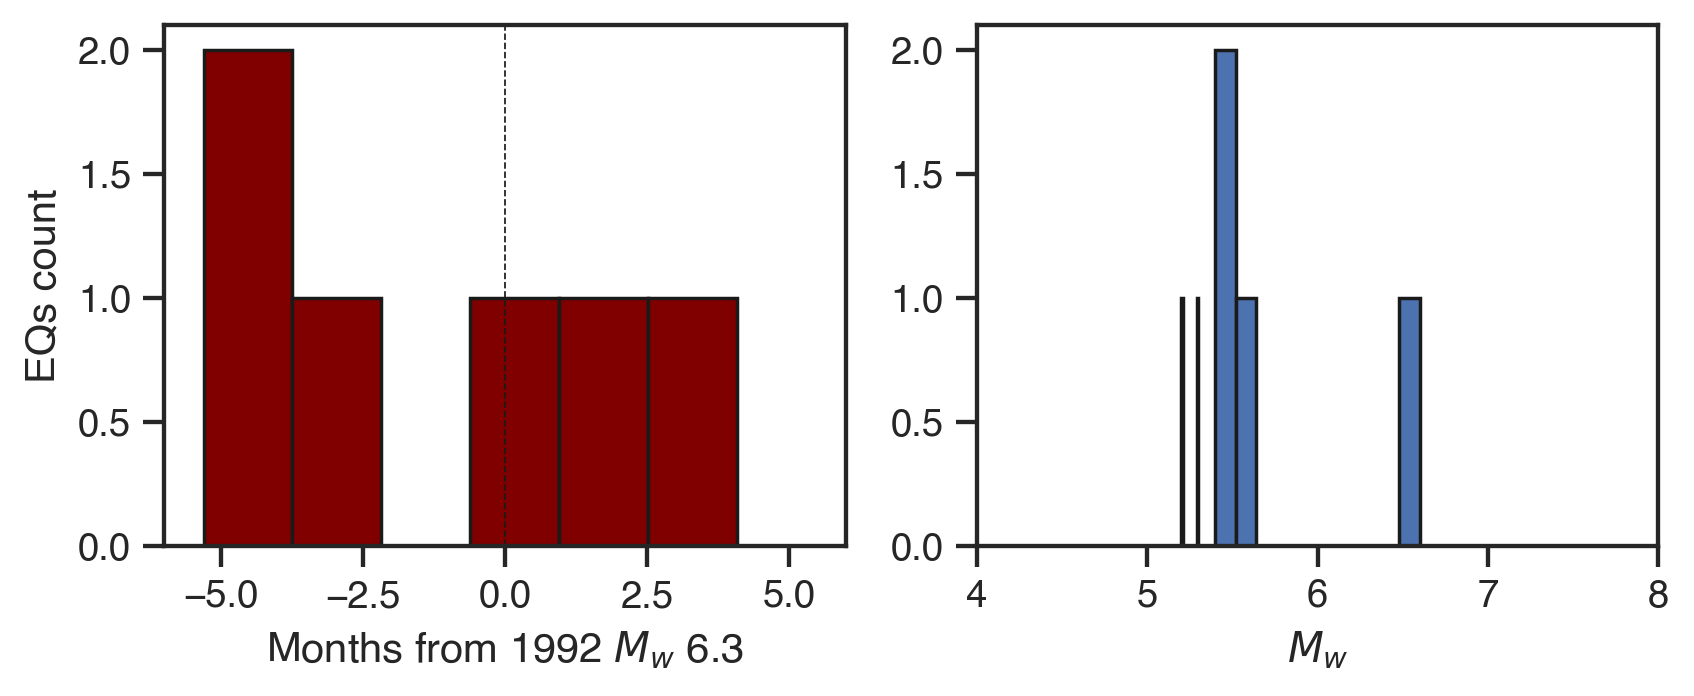

In [153]:
# maroon band (Mw 6.3,  1992-06-02)

mega_maroon = -12.574554
t1 = mega_maroon - 0.5
t2 = mega_maroon + 0.5

maroon_eq_Java = data_dgoing[(data_dgoing['YEARS'] > t1) & (data_dgoing['YEARS'] < t2)]

#normalize around megathrust earthquake for maroon band
maroon_eq_Java['YEARS'] = ((maroon_eq_Java['YEARS'] - mega_maroon))

# Convert year to months
maroon_eq_Java['MONTHS'] = maroon_eq_Java['YEARS'] * 12

# counts
maroon_count = maroon_eq_Java.groupby('MONTHS').size()


# figsize = (7,3)
# dpi=250

fig, ax = plt.subplots(1, 2, dpi=dpi, figsize = figsize, sharex= False)
fig1=ax[0]
fig2=ax[1]


## left plot - Eqs counts vs years
bins = 6
alpha = 1

fig1.hist(maroon_count.index, bins=bins, weights=maroon_count.values,
          edgecolor='k', lw=1, alpha=alpha, color='maroon')


# fig1.legend(loc = 'upper left',
#             fontsize = 10,
#             facecolor="white",
#             framealpha=1,
#             edgecolor="black",
#             markerscale=1)

fig1.set_xlabel('Months from 1992 $M_w$ 6.3')
fig1.set_ylabel('EQs count')

fig1.axvline(x=0, color='k', lw=0.5, ls='--', alpha=alpha)

fig1.set_xlim([-6, 6])
# fig1.set_ylim([0, 10])

plt.tight_layout()


## ####right plot - difference between counts +1/-1 years

before_eq = maroon_eq_Java[(maroon_eq_Java['YEARS'] <= 0) & (maroon_eq_Java['YEARS'] >= -0.5)]
after_eq = maroon_eq_Java[(maroon_eq_Java['YEARS'] > 0) & (maroon_eq_Java['YEARS'] < 0.5)]

before_eq = before_eq.MW
after_eq = after_eq.MW

bins = 10
fig2.hist(before_eq, color='b', edgecolor='k', bins = bins, lw=1, alpha=alpha, label='1 yr before')
fig2.hist(after_eq, color='magenta', edgecolor='k', lw=1, bins = bins, alpha=alpha, label='1 yr after')

fig2.set_xlim([4, 8])

fig2.set_xlabel('$M_w$')
# fig2.set_ylabel('Count')
# fig2.legend(loc = 'upper right',
#             fontsize = 10,
#             facecolor="white",
#             framealpha=1,
#             edgecolor="black",
#             markerscale=1)


plt.savefig("/Users/mohd0001/PhD_Monash/Paper2/output/hist/Maroon-countsYears.pdf"
            , dpi = 500, transparent= True, bbox_inches='tight')

### Orange band - 1984 $M_w$ 7.1

/Users/mohd0001/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/mohd0001/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


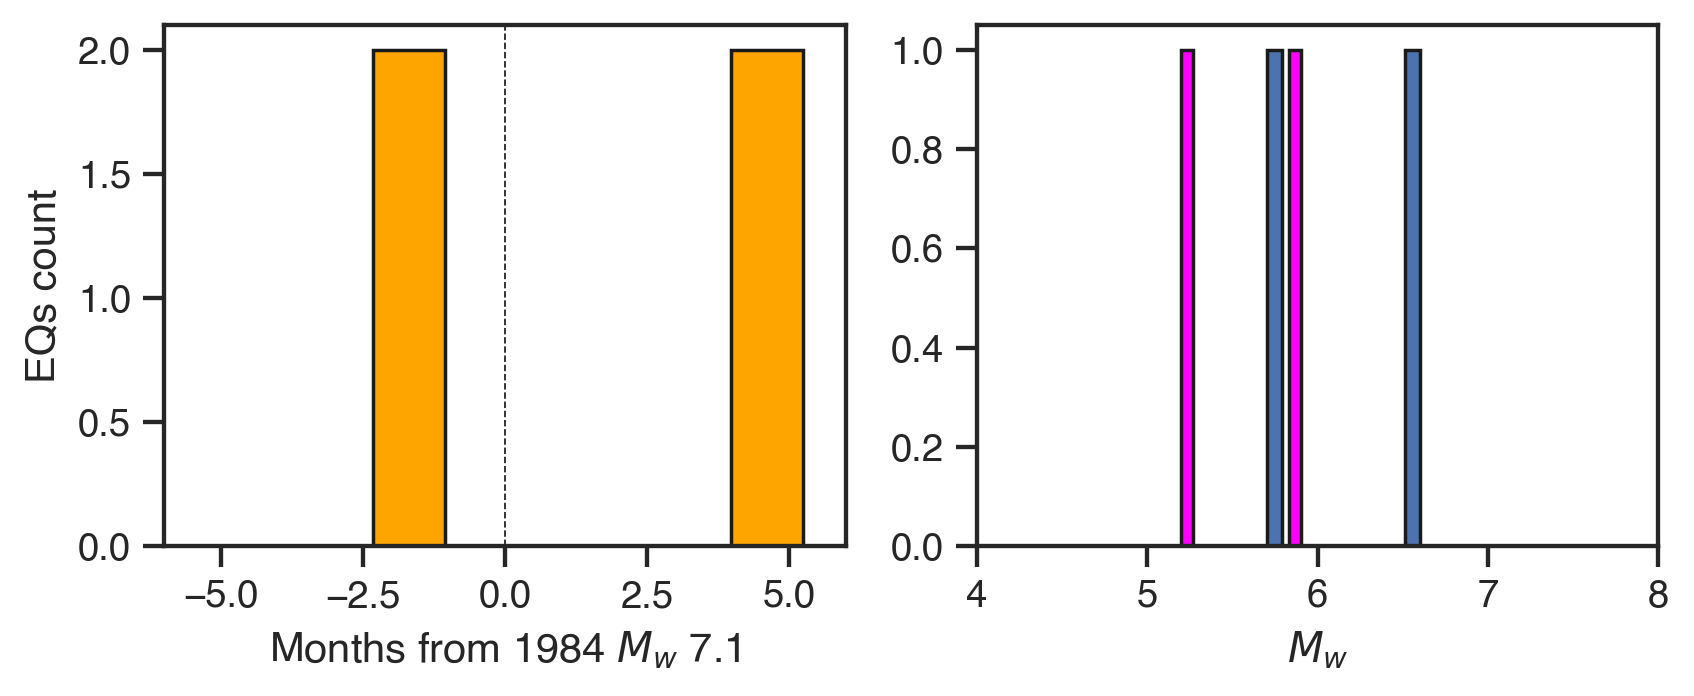

In [154]:
# orange band

mega_orange = -20.120661
t1 = mega_orange - 0.5
t2 = mega_orange + 0.5

orange_eq_Java = data_dgoing[(data_dgoing['YEARS'] > t1) & (data_dgoing['YEARS'] < t2)]

#normalize around megathrust earthquake for orange band
orange_eq_Java['YEARS'] = ((orange_eq_Java['YEARS'] - mega_orange))

# Convert year to months
orange_eq_Java['MONTHS'] = orange_eq_Java['YEARS'] * 12

# counts
orange_count = orange_eq_Java.groupby('MONTHS').size()

# figsize = (7,3)
# dpi=250

fig, ax = plt.subplots(1, 2, dpi=dpi, figsize = figsize, sharex= False)
fig1=ax[0]
fig2=ax[1]


## left plot - Eqs counts vs years
bins = 6
alpha = 1

fig1.hist(orange_count.index, bins=bins, weights=orange_count.values,
          edgecolor='k', lw=1, alpha=alpha, color='orange')


# fig1.legend(loc = 'upper left',
#             fontsize = 10,
#             facecolor="white",
#             framealpha=1,
#             edgecolor="black",
#             markerscale=1)

fig1.set_xlabel('Months from 1984 $M_w$ 7.1')
fig1.set_ylabel('EQs count')

fig1.axvline(x=0, color='k', lw=0.5, ls='--', alpha=alpha)

fig1.set_xlim([-6, 6])
# fig1.set_ylim([0, 10])

plt.tight_layout()


## ####right plot - difference between counts +1/-1 years

before_eq = orange_eq_Java[(orange_eq_Java['YEARS'] <= 0) & (orange_eq_Java['YEARS'] >= -0.5)]
after_eq = orange_eq_Java[(orange_eq_Java['YEARS'] > 0) & (orange_eq_Java['YEARS'] < 0.5)]

before_eq = before_eq.MW
after_eq = after_eq.MW

bins = 10
fig2.hist(before_eq, color='b', edgecolor='k', bins = bins, lw=1, alpha=alpha, label='1 yr before')
fig2.hist(after_eq, color='magenta', edgecolor='k', bins = bins, lw=1, alpha=alpha, label='1 yr after')

fig2.set_xlim([4, 8])

fig2.set_xlabel('$M_w$')
# fig2.set_ylabel('Count')
# fig2.legend(loc = 'upper right',
#             fontsize = 10,
#             facecolor="white",
#             framealpha=1,
#             edgecolor="black",
#             markerscale=1)


plt.savefig("/Users/mohd0001/PhD_Monash/Paper2/output/hist/Orange-countsYears.pdf"
            , dpi = 500, transparent= True, bbox_inches='tight')

### Olive band - 1976 $M_w$ 7.0

/Users/mohd0001/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/mohd0001/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


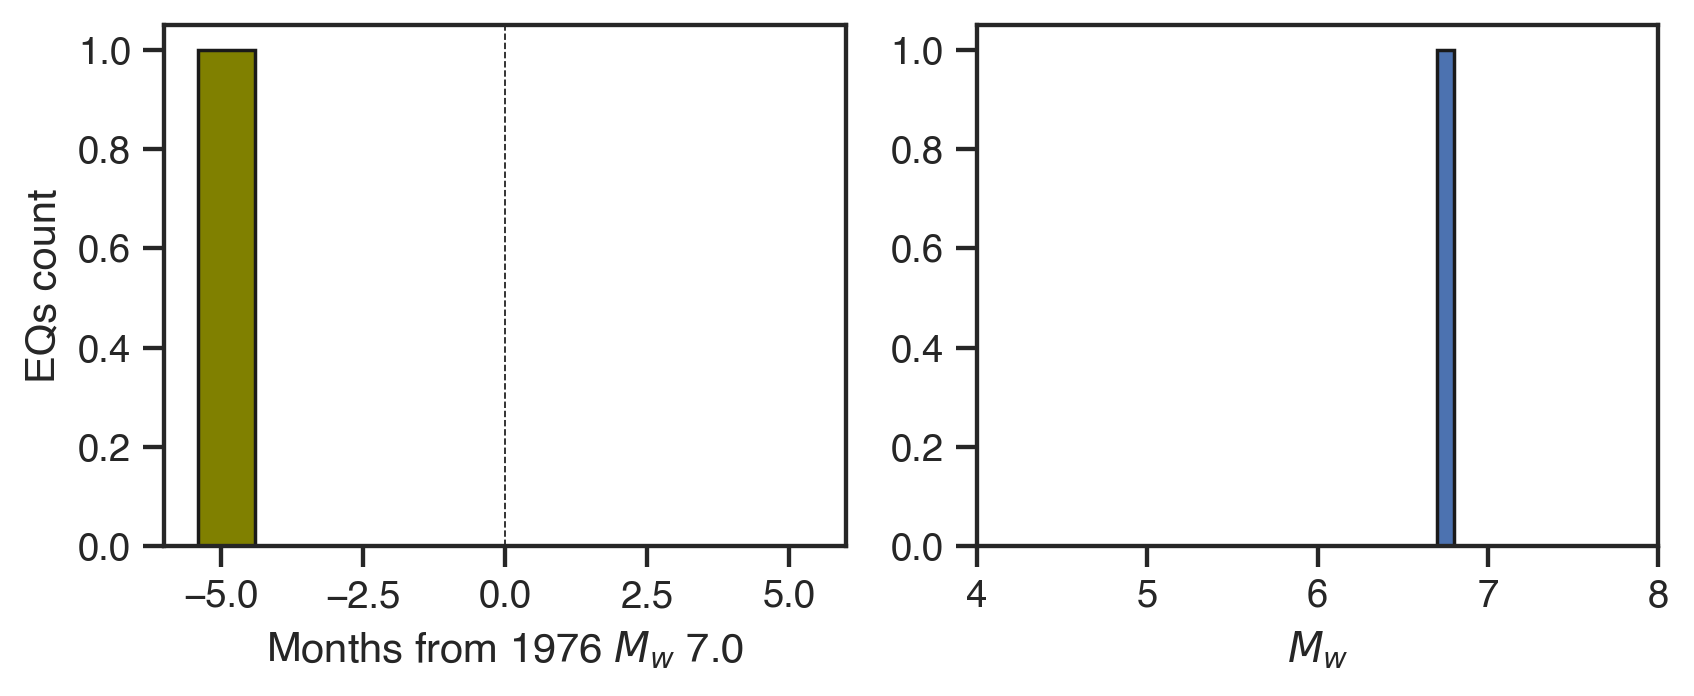

In [155]:
# olive band

mega_olive = -28.536944
t1 = mega_olive - 0.5
t2 = mega_olive + 0.5

olive_eq_Java = data_dgoing[(data_dgoing['YEARS'] > t1) & (data_dgoing['YEARS'] < t2)]

#normalize around megathrust earthquake for olive band
olive_eq_Java['YEARS'] = ((olive_eq_Java['YEARS'] - mega_olive))

# Convert year to months
olive_eq_Java['MONTHS'] = olive_eq_Java['YEARS'] * 12


# counts
olive_count = olive_eq_Java.groupby('MONTHS').size()


# figsize = (7,3)
# dpi=250

fig, ax = plt.subplots(1, 2, dpi=dpi, figsize = figsize, sharex= False)
fig1=ax[0]
fig2=ax[1]


## left plot - Eqs counts vs years
bins = 1
alpha = 1

fig1.hist(olive_count.index, bins=bins, weights=olive_count.values,
          edgecolor='k', lw=1, alpha=alpha, color='olive')


# fig1.legend(loc = 'upper left',
#             fontsize = 10,
#             facecolor="white",
#             framealpha=1,
#             edgecolor="black",
#             markerscale=1)

fig1.set_xlabel('Months from 1976 $M_w$ 7.0')
fig1.set_ylabel('EQs count')

fig1.axvline(x=0, color='k', lw=0.5, ls='--', alpha=alpha)

fig1.set_xlim([-6, 6])
# fig1.set_ylim([0, 5])

plt.tight_layout()


## ####right plot - difference between counts +1/-1 years

before_eq = olive_eq_Java[(olive_eq_Java['YEARS'] <= 0) & (olive_eq_Java['YEARS'] >= -0.5)]
after_eq = olive_eq_Java[(olive_eq_Java['YEARS'] > 0) & (olive_eq_Java['YEARS'] < 0.5)]

before_eq = before_eq.MW
after_eq = after_eq.MW

bins = 10
fig2.hist(before_eq, color='b', edgecolor='k', bins = bins, lw=1, alpha=alpha, label='1 yr before')
fig2.hist(after_eq, color='magenta', edgecolor='k', bins = bins, lw=1, alpha=alpha, label='1 yr after')

fig2.set_xlim([4, 8])
# fig2.set_ylim([0, 5])

fig2.set_xlabel('$M_w$')
# fig2.set_ylabel('Count')
# fig2.legend(loc = 'upper left',
#             fontsize = 10,
#             facecolor="white",
#             framealpha=1,
#             edgecolor="black",
#             markerscale=1)


plt.savefig("/Users/mohd0001/PhD_Monash/Paper2/output/hist/Olive-countsYear.pdf"
            , dpi = 500, transparent= True, bbox_inches='tight')